In [207]:
import os
import numpy as np

from skimage.transform import resize
from scipy.ndimage import rotate
from skimage.color import gray2rgb
import torch
import tensorflow_datasets as tfds
from segment_anything import sam_model_registry
from tqdm import tqdm
import pandas as pd
import h5py
import argparse

from visualization_utils import (crop_image,
                                 extract_coords,
                                 extract_roi,
                                 visualize_features,
                                 hu_to_rgb_vectorized,
                                 pca_colorize)

from tfds_dense_descriptor import (prepare_image, 
                                    load_model,
                                    get_voxels,
                                    apply_window_ct,
                                    get_dense_descriptor,
                                    )
from train_models import positional_encoding_3d

In [2]:
ls '../../../Data/PET-CT'


data/  lung_radiomics/


In [3]:
model_name = "medsam"
model_path = "../../PET-CT/medsam_vit_b.pth"
dataset_path = os.path.join('../../../Data/PET-CT', 'lung_radiomics')
ds_path = os.path.join('../../../Data/PET-CT', 'lung_radiomics', 'lung_radiomics_datasets.hdf5')
df_metdata_path = os.path.join('../../../Data/PET-CT', 'lung_radiomics', 'lung_radiomics_datasets.csv')
second_modality = 'ct'
use_tfds = ds_path is None
gpu_device = 0
torch.cuda.set_device(int(gpu_device))
preprocess_info=pd.read_csv("../../../Data/PET-CT/lung_radiomics/process_info.csv")
preprocess_info_true=preprocess_info[preprocess_info["pet_liver"]==True]
preprocess_info_false=preprocess_info[preprocess_info["pet_liver"]==False]

In [4]:
model = load_model(model_name, model_path)
dataset_name = 'stanford_dataset'#'santa_maria_dataset', 
modalities = ['pet', second_modality]

In [5]:
df_metadata = pd.read_csv(df_metdata_path)
df_metadata['label'] = (df_metadata['egfr'] == 'Mutant').astype(int)
patient2label = dict(zip(df_metadata['patient_id'], df_metadata['label']))
if second_modality == 'pet':
    df_metadata = df_metadata[np.logical_or(df_metadata['has_petct'], df_metadata['has_petchest'])]
else:
    df_metadata = df_metadata[df_metadata[f'has_{"".join(modalities)}']]
df_metadata.reset_index(inplace=True, drop=True)

In [6]:
dataset_name_sort = dataset_name.replace('_dataset', '')
patient_ids = list(df_metadata[df_metadata['dataset'] == dataset_name_sort]['patient_id'].unique())

In [7]:
patient_id=patient_ids[52]
patient_id

'R01-038'

In [8]:
label = patient2label[patient_id]
img_raw_pet, mask_raw_pet, _, spatial_res_pet = get_voxels(ds_path, patient_id, "pet",True)
print(np.shape(img_raw_pet))
print(np.min(img_raw_pet),np.max(img_raw_pet))
label = patient2label[patient_id]
img_raw_pet_f, mask_raw_pet_f, _, spatial_res_pet_f = get_voxels(ds_path, patient_id, "pet",False)
print(np.shape(img_raw_pet_f))
print(np.min(img_raw_pet_f),np.max(img_raw_pet_f))

(192, 192, 4)
0.0 1.8638959619546018
(192, 192, 4)
0 10201


In [9]:
img_raw_ct, mask_raw_ct, _, spatial_res_ct = get_voxels(ds_path, patient_id, "ct",False)
print(np.shape(img_raw_ct))
print(np.min(img_raw_ct),np.max(img_raw_ct))

(512, 512, 5)
-2047 1249


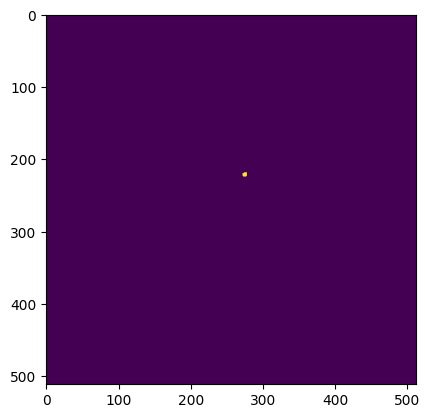

In [26]:
import matplotlib.pyplot as plt
plt.imshow(mask_raw_ct[:,:,1])

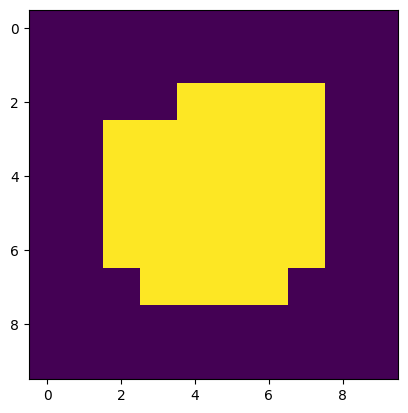

In [41]:
mask_tst=mask_raw_ct[:,:,1]
xmin, ymin, xmax, ymax = extract_coords(mask_tst,2)
plt.imshow(mask_tst[ymin:ymax+1,xmin:xmax+1])

In [12]:
if patient_id[:2]=="sm":
    info_name="sm"
else:
    info_name=patient_id[:3]
info_dataset=preprocess_info_true[preprocess_info_true["dataset"]==info_name]
img_mean=float(info_dataset["mean"])
img_std=float(info_dataset["std"])
img_raw_pet = (img_raw_pet - img_mean)/ img_std
print(np.min(img_raw_pet),np.max(img_raw_pet))

-0.2650268369624856 6.6026625260265535


/tmp/ipykernel_1351/3032886966.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  img_mean=float(info_dataset["mean"])
/tmp/ipykernel_1351/3032886966.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  img_std=float(info_dataset["std"])


In [13]:
if patient_id[:2]=="sm":
    info_name="sm"
else:
    info_name=patient_id[:3]
info_dataset=preprocess_info_false[preprocess_info_false["dataset"]==info_name]
img_mean=float(info_dataset["mean"])
img_std=float(info_dataset["std"])
img_raw_pet_f = (img_raw_pet_f - img_mean)/ img_std
print(np.min(img_raw_pet_f),np.max(img_raw_pet_f))

-0.09937862444182811 4.5960389192529805


/tmp/ipykernel_1351/982328013.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  img_mean=float(info_dataset["mean"])
/tmp/ipykernel_1351/982328013.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  img_std=float(info_dataset["std"])


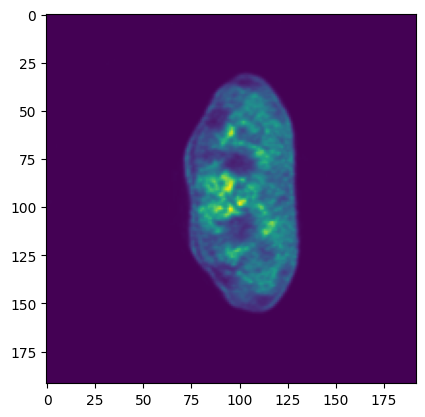

In [14]:
plt.imshow(img_raw_pet[:,:,0])

In [15]:
img_raw_ct = apply_window_ct(img_raw_ct, width=1800, level=40)
print(np.shape(img_raw_ct),np.min(img_raw_ct),np.max(img_raw_ct))

(512, 512, 5) 0.0 1.0


In [57]:
np.ceil(3.1)

4.0

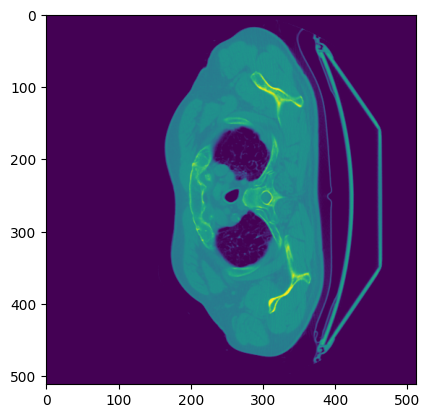

In [16]:
plt.imshow(img_raw_ct[:,:,0])

In [178]:
def extract_coords(mask, margin):
    indices = np.array(np.where(mask))
    ymin = np.min(indices[0, :]) - margin
    xmin = np.min(indices[1, :]) - margin
    ymax = np.max(indices[0, :]) + margin
    xmax = np.max(indices[1, :]) + margin

    h = max((ymax - ymin), margin)
    w = max((xmax - xmin), margin)
    xmax = xmin + w
    ymax = ymin + h
    return xmin, ymin, xmax, ymax

In [179]:
def crop_image(img, xmin, ymin, xmax, ymax):
    h, w = img.shape[0:2]
    ymin, ymax = [max(0, min(v, h)) for v in [ymin, ymax+1]]
    xmin, xmax = [max(0, min(v, w)) for v in [xmin, xmax+1]]
    cropped = img[ymin:ymax, xmin:xmax]
    return cropped

In [180]:
def extract_roi(img, mask, margin=1):
    xmin, ymin, xmax, ymax = extract_coords(mask, margin)
    if img.shape[0:2] != mask.shape[0:2]:
        h = img.shape[0] / mask.shape[0]
        w = img.shape[1] / mask.shape[1]
        xmin, ymin, xmax, ymax = [int(v) for v in [xmin*w, ymin*h, xmax*w, ymax*h]]
        h = max((ymax - ymin), margin)
        w = max((xmax - xmin), margin)
        xmax = xmin + w
        ymax = ymin + h
    return crop_image(img, xmin, ymin, xmax, ymax)

In [181]:
def generate_features(model, img_3d, mask_3d, tqdm_text, display=False):
    """ Extract feature map of each slice and crop them to focus on nodule region.

    Args:
        model (torch.nn.Module): ViT image encoder
        img_3d (np.array): CT or PET 3D data with shape (H, W, slices, Ch).
        mask_3d (np.array): 3D nodule boolean mask with shape (H, W, slices).
        tqdm_text (str): description to display in the tqdm loading bar.
        display (bool, optional): To visualize images and extracted features. Defaults to False.

    Returns:
        features_list (List(np.array)): featuremap of each slice cropped to the nodule region.
        mask_list (List(np.array)):  binary mask of each slice cropped to the nodule region.

    """
    bigger_mask = np.sum(mask_3d, axis=-1) > 0

    h, w = bigger_mask.shape
    xmin, ymin, xmax, ymax = extract_coords(bigger_mask, margin=2)
    crop_size = max(xmax-xmin,ymax-ymin)*2
    print("xmin, ymin, ww, hh",xmin, ymin, xmax-xmin, ymax-ymin)
    print("crop_size",crop_size)
    xmid, ymid = int(xmin + (xmax-xmin)/2), int(ymin + (ymax-ymin)/2)
    xmin, ymin, xmax, ymax = xmid-crop_size, ymid-crop_size, xmid+crop_size, ymid+crop_size
    
    
    img_3d = crop_image(img_3d, xmin, ymin, xmax, ymax)
    mask_3d = crop_image(mask_3d, xmin, ymin, xmax, ymax)
    bigger_mask = crop_image(bigger_mask, xmin, ymin, xmax, ymax)
    print("after_shape:",np.shape(img_3d))
    img_3d_crop=img_3d
    #print(xmin, ymin, xmax, ymax)
    #print(np.shape(img_3d),np.shape(mask_3d),np.shape(bigger_mask))

    features_list = []
    mask_list = []
    for slice_i in tqdm(range(0, img_3d.shape[2]), desc=tqdm_text, leave=False):
        mask = mask_3d[:, :, slice_i] > 0
        if mask.sum() < 1:
            continue
        img = img_3d[:, :, slice_i]
        print("imgs shape:",np.shape(img))
        features = get_dense_descriptor(model, img)
        print("features shape:",np.shape(features))
        crop_features = extract_roi(features, bigger_mask)
        print("features cropped shape:",np.shape(crop_features))
        crop_mask = extract_roi(mask, bigger_mask)
        features_list.append(crop_features)
        mask_list.append(crop_mask)
        if display:
            visualize_features(img, features, mask)
    return features_list, mask_list, img_3d_crop,mask_3d, bigger_mask

In [182]:
features_ct, features_mask_ct,img_3d_crop_ct,mask_3d_ct,bigger_mask_ct= generate_features(model=model,
                                            img_3d=img_raw_ct,
                                            mask_3d=mask_raw_ct,
                                            tqdm_text=f'"ct" {patient_id}',
                                            display=False)

xmin, ymin, ww, hh 267 215 15 12
crop_size 30
after_shape: (61, 61, 5)


"ct" R01-038:   0%|                                                                                                                                | 0/5 [00:00<?, ?it/s]

imgs shape: (61, 61)


"ct" R01-038:  40%|████████████████████████████████████████████████                                                                        | 2/5 [00:00<00:00,  4.05it/s]

features shape: (64, 64, 256)
features cropped shape: (11, 14, 256)
imgs shape: (61, 61)


"ct" R01-038:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:00<00:00,  3.07it/s]

features shape: (64, 64, 256)
features cropped shape: (11, 14, 256)
imgs shape: (61, 61)


"ct" R01-038:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:01<00:00,  2.82it/s]

features shape: (64, 64, 256)
features cropped shape: (11, 14, 256)
imgs shape: (61, 61)


features shape: (64, 64, 256)
features cropped shape: (11, 14, 256)


(11, 14) [False  True]


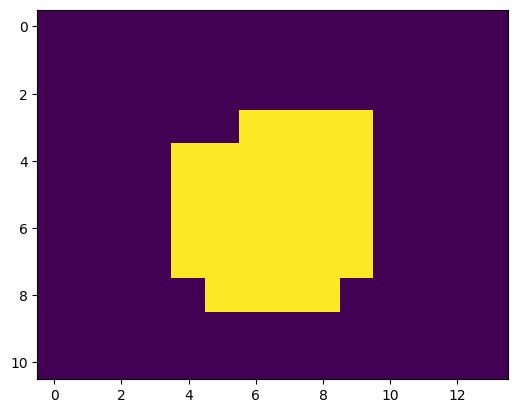

In [186]:
aaa=np.array(features_mask_ct)[0]
plt.imshow(aaa)
print(np.shape(aaa),np.unique(aaa))

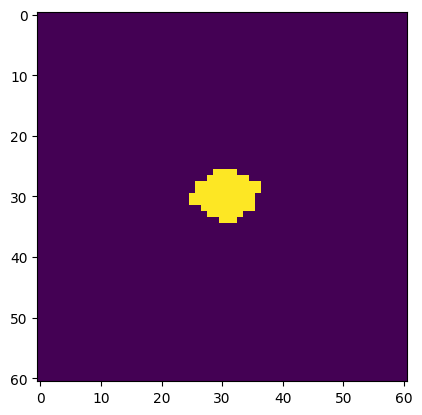

In [187]:
plt.imshow(bigger_mask_ct)

In [188]:
indices = np.array(np.where(bigger_mask_ct))
ymin = np.min(indices[0, :])
xmin = np.min(indices[1, :])
ymax = np.max(indices[0, :])
xmax = np.max(indices[1, :])
print(ymin,xmin,ymax,xmax)
print(ymin+(ymax-ymin)/2,xmin+(xmax-xmin)/2)

26 25 34 36
30.0 30.5


In [189]:
60-34

26

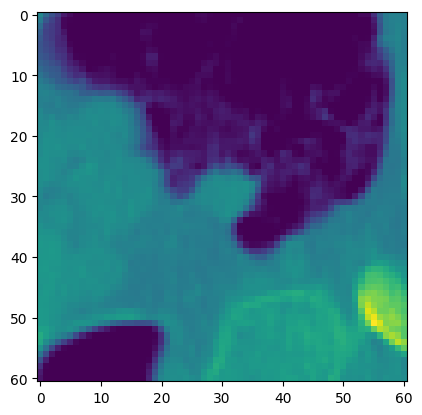

In [190]:
plt.imshow(img_3d_crop_ct[:,:,3])

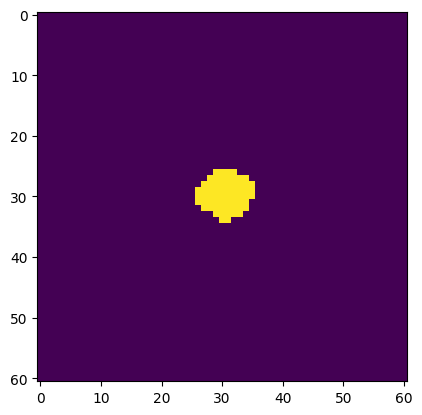

In [191]:
plt.imshow(mask_3d_ct[:,:,3])

In [192]:
features_pet, features_mask_pet,img_3d_crop_pet,mask_3d_pet,bigger_mask_pet= generate_features(model=model,
                                            img_3d=img_raw_pet,
                                            mask_3d=mask_raw_pet,
                                            tqdm_text=f'pet {patient_id}',
                                            display=False)

xmin, ymin, ww, hh 99 83 6 5
crop_size 12
after_shape: (25, 25, 4)


pet R01-038:   0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

imgs shape: (25, 25)


pet R01-038:  50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  4.15it/s]

features shape: (64, 64, 256)
features cropped shape: (8, 11, 256)
imgs shape: (25, 25)


pet R01-038:  75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  3.26it/s]

features shape: (64, 64, 256)
features cropped shape: (8, 11, 256)
imgs shape: (25, 25)


features shape: (64, 64, 256)
features cropped shape: (8, 11, 256)


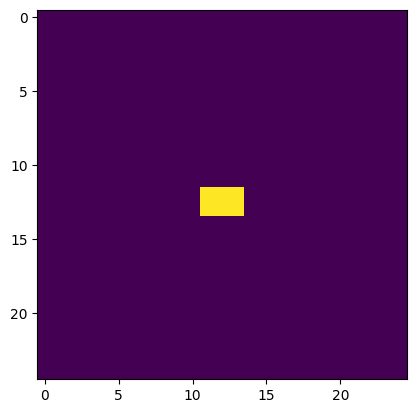

In [193]:
plt.imshow(bigger_mask_pet)

In [194]:
indices = np.array(np.where(bigger_mask_pet))
ymin = np.min(indices[0, :])
xmin = np.min(indices[1, :])
ymax = np.max(indices[0, :])
xmax = np.max(indices[1, :])
print(ymin,xmin,ymax,xmax,np.shape(bigger_mask_pet))
print(ymin+(ymax-ymin)/2,xmin+(xmax-xmin)/2)

12 11 13 13 (25, 25)
12.5 12.0


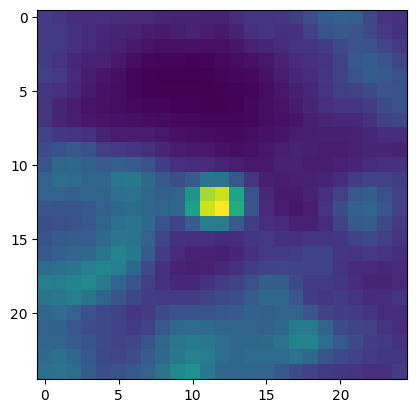

In [195]:
plt.imshow(img_3d_crop_pet[:,:,2])

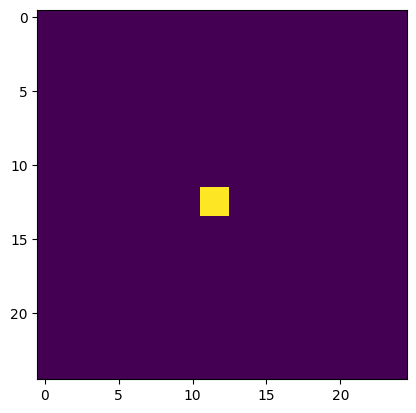

In [196]:
plt.imshow(mask_3d_pet[:,:,1])

In [209]:

pca_img=pca_colorize(np.shape(features_pet))
plt.imshow(pca_img)

AttributeError: 'tuple' object has no attribute 'shape'

In [198]:
np.shape(features_mask_pet)

(3, 4, 5)

In [169]:
np.shape(features_mask_ct)[0:2]

(4, 8)

In [170]:
np.shape(features_ct)

(4, 8, 11, 256)

In [218]:
noise_val = 10
flip = 'None'
angle = 90
noise = np.random.random(3) * noise_val - noise_val/2
scale_noise = np.random.uniform(0.85, 1.15)
print(np.min(features_ct),np.max(features_ct))
print(noise)

-1.0573568 0.7957064
[4.1220348  0.36458397 1.24208949]


In [258]:
features_ct_dataset = np.transpose(np.stack(features_ct, axis=0), axes=(3, 0, 1, 2))
masks_ct_dataset = resize(np.array(features_mask_ct), np.shape(features_ct)[0:2], order=0)
masks_ct_dataset = np.expand_dims(masks_ct_dataset, axis=-1)

print(np.shape(masks_ct_dataset))

masks_ct_dataset = np.transpose(np.stack(masks_ct_dataset, axis=0), axes=(1, 2, 0, 3))  # (slice, h, w, 1) -> (h, w, slice, 1)
h_orig, w_orig = masks_ct_dataset.shape[0:2]
features_ct_dataset = np.transpose(features_ct_dataset, axes=(2, 3, 1, 0))  # (h, w, slice, feat_dim)
h_new, w_new = features_ct_dataset.shape[0], features_ct_dataset.shape[1]

x, y, z = np.meshgrid(np.arange(0, features_ct_dataset.shape[0]),
                      np.arange(0, features_ct_dataset.shape[1]),
                      np.arange(0, features_ct_dataset.shape[2]))
x = (x.flatten() / w_new).flatten() * w_orig * spatial_res_ct[0]
y = (y.flatten() / h_new).flatten() * h_orig * spatial_res_ct[1]
z = (z.flatten()).flatten() * spatial_res_ct[2]

print("pre x: ",np.shape(x),np.min(x),np.max(x))
print("pre y: ",np.shape(y),np.min(y),np.max(y))
print("pre z: ",np.shape(z),np.min(z),np.max(z))

x = (x - x.mean() + noise[0])
y = (y - y.mean() + noise[1])
z = (z - z.mean() + noise[2])

print("post x: ",np.shape(x),np.min(x),np.max(x))
print("post y: ",np.shape(y),np.min(y),np.max(y))
print("post z: ",np.shape(z),np.min(z),np.max(z))

print("pre feature: ",np.shape(features_ct_dataset),np.min(features_ct_dataset),np.max(features_ct_dataset))

pe = positional_encoding_3d(x, y, z, D=256, scale=10000)
features_ct_dataset = features_ct_dataset.reshape(-1, 256) + pe / 4 


print("post feature: ",np.shape(features_ct_dataset),np.min(features_ct_dataset),np.max(features_ct_dataset))
features_ct_dataset=torch.as_tensor(features_ct_dataset, dtype=torch.float32)

(4, 12, 11, 1)
pre x:  (768,) 0.0 7.385250300168991
pre y:  (768,) 0.0 14.648430347442627
pre z:  (768,) 0.0 9.809999942779541
post x:  (768,) 0.4294096451010727 7.814659945270064
post y:  (768,) -6.959631205128234 7.688799142314393
post z:  (768,) -3.662910486032038 6.147089456747503
pre feature:  (12, 16, 4, 256) -1.0573568 0.7957064
post feature:  (768, 256) -1.2380542287091671 0.8522825046360395


In [257]:
features_pet_dataset = np.transpose(np.stack(features_pet, axis=0), axes=(3, 0, 1, 2))
masks_pet_dataset = resize(np.array(features_mask_pet), np.shape(features_pet)[0:2], order=0)
masks_pet_dataset = np.expand_dims(masks_pet_dataset, axis=-1)

print(np.shape(masks_pet_dataset))

masks_pet_dataset = np.transpose(np.stack(masks_pet_dataset, axis=0), axes=(1, 2, 0, 3))  # (slice, h, w, 1) -> (h, w, slice, 1)
h_orig, w_orig = masks_ct_dataset.shape[0:2]
features_pet_dataset = np.transpose(features_pet_dataset, axes=(2, 3, 1, 0))  # (h, w, slice, feat_dim)
h_new, w_new = features_pet_dataset.shape[0], features_pet_dataset.shape[1]

x, y, z = np.meshgrid(np.arange(0, features_pet_dataset.shape[0]),
                      np.arange(0, features_pet_dataset.shape[1]),
                      np.arange(0, features_pet_dataset.shape[2]))
x = (x.flatten() / w_new).flatten() * w_orig * spatial_res_ct[0]
y = (y.flatten() / h_new).flatten() * h_orig * spatial_res_ct[1]
z = (z.flatten()).flatten() * spatial_res_ct[2]

print("pre x: ",np.shape(x),np.min(x),np.max(x))
print("pre y: ",np.shape(y),np.min(y),np.max(y))
print("pre z: ",np.shape(z),np.min(z),np.max(z))

x = (x - x.mean() + noise[0])
y = (y - y.mean() + noise[1])
z = (z - z.mean() + noise[2])

print("post x: ",np.shape(x),np.min(x),np.max(x))
print("post y: ",np.shape(y),np.min(y),np.max(y))
print("post z: ",np.shape(z),np.min(z),np.max(z))

print("pre feature: ",np.shape(features_pet_dataset),np.min(features_pet_dataset),np.max(features_pet_dataset))

pe = positional_encoding_3d(x, y, z, D=256, scale=10000)
features_pet_dataset = features_pet_dataset.reshape(-1, 256) + pe / 4 


print("post feature: ",np.shape(features_pet_dataset),np.min(features_pet_dataset),np.max(features_pet_dataset))
features_pet_dataset=torch.as_tensor(features_pet_dataset, dtype=torch.float32)

(3, 8, 2, 1)
pre x:  (384,) 0.0 4.699704736471176
pre y:  (384,) 0.0 21.97264552116394
pre z:  (384,) 0.0 6.539999961853027
post x:  (384,) 1.7721824269499802 6.471887163421156
post y:  (384,) -10.621738791988891 11.35090672917505
post z:  (384,) -2.027910495568781 4.512089466284246
pre feature:  (8, 16, 3, 256) -0.8468449 0.74821836
post feature:  (384, 256) -0.9135727975068115 0.9649879937118566


In [248]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Optional, Tuple, Type
from models_archs import MLPBlock, BidirectionalCrossAttentionLayer

In [252]:
input_dim=256
mlp_ratio_ct=4
dim_feedforward=int(mlp_ratio_ct*input_dim)
num_heads_ct=4
activation="gelu"
batch_first=True
dropout=0.5
num_layers_ct=2
num_classes=2
num_layers_cross_att=4

transformer_encoder_ct = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=input_dim,
                                                                           dim_feedforward=int(mlp_ratio_ct*input_dim),
                                                                           nhead=num_heads_ct,
                                                                           activation="gelu",
                                                                           batch_first=True,
                                                                           dropout=0.5),
                                                            num_layers=num_layers_ct)
transformer_encoder_pet = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=input_dim,
                                                                                dim_feedforward=int(mlp_ratio_ct*input_dim),
                                                                                nhead=num_heads_ct,
                                                                                activation="gelu",
                                                                                batch_first=True,
                                                                                dropout=0.5),
                                                     num_layers=num_layers_ct)

norm_ct = nn.LayerNorm(input_dim)
norm_pet = nn.LayerNorm(input_dim)

cls_token_ct = nn.Parameter(torch.randn(1, 1, input_dim))
cls_token_pet = nn.Parameter(torch.randn(1, 1, input_dim))

classifier_ct = MLPBlock(input_dim, input_dim*2, num_classes, dropout_rate=0.1)
classifier_pet = MLPBlock(input_dim, input_dim*2, num_classes, dropout_rate=0.1)

projection_petct = MLPBlock(input_dim*2, input_dim, input_dim, dropout_rate=0.1)
cross_attention = BidirectionalCrossAttentionLayer(input_dim, num_heads_ct,num_layers_cross_att)

    
classifier_petct = MLPBlock(input_dim, input_dim*2, num_classes, dropout_rate=0.1)

In [259]:
x_ct=features_ct_dataset.unsqueeze(0)

batch, seq_len, feature_dim = x_ct.shape
x_ct = torch.cat([cls_token_ct.repeat(batch, 1, 1), x_ct], dim=1)
print("ct process1:",np.shape(x_ct))
x_ct = norm_ct(x_ct)
print("ct process2:",np.shape(x_ct))
x_ct = transformer_encoder_ct(x_ct)
print("ct process3:",np.shape(x_ct))
ct_cls_token = x_ct[:, 0, :]
print("ct_cls_token1:",np.shape(ct_cls_token))

ct process1: torch.Size([1, 769, 256])
ct process2: torch.Size([1, 769, 256])
ct process3: torch.Size([1, 769, 256])
ct_cls_token1: torch.Size([1, 256])


In [261]:
x_pet=features_pet_dataset.unsqueeze(0)

batch, seq_len, feature_dim = x_pet.shape
x_pet = torch.cat([cls_token_pet.repeat(batch, 1, 1), x_pet], dim=1)
print("pet process1:",np.shape(x_pet))
x_pet = norm_pet(x_pet)
print("pet process2:",np.shape(x_pet))
x_pet = transformer_encoder_pet(x_pet)
print("pet process3:",np.shape(x_pet))
pet_cls_token = x_pet[:, 0, :]
print("petpet_cls_token1:",np.shape(pet_cls_token))

pet process1: torch.Size([1, 385, 256])
pet process2: torch.Size([1, 385, 256])
pet process3: torch.Size([1, 385, 256])
petpet_cls_token1: torch.Size([1, 256])


In [264]:
x_ct_attn,x_pet_attn=cross_attention(modality_a=x_pet, modality_b=x_ct)
#Sumar x_ct
print("after cross_attention:",np.shape(x_ct_attn),np.shape(x_pet_attn))
ct_cls_token = x_ct_attn[:, 0, :]
pet_cls_token = x_pet_attn[:, 0, :]

print("ct_cls_:",np.shape(ct_cls_token),np.shape(pet_cls_token))

logits_ct = classifier_ct(ct_cls_token)
logits_pet = classifier_pet(pet_cls_token)

print("after classifier:",np.shape(logits_ct),np.shape(logits_pet))

petct_cls_token = torch.cat([ct_cls_token, pet_cls_token], dim=1)

print("after concat:",np.shape(petct_cls_token))
petct_cls_token = projection_petct(petct_cls_token)
print("after projection_petct:",np.shape(petct_cls_token))
logits_petct = classifier_petct(petct_cls_token)
print("after classifier_petct:",np.shape(logits_petct))

Cross_att_shape torch.Size([1, 385, 256]) torch.Size([1, 385, 256]) torch.Size([1, 769, 256])
Cross_att_shape_sum torch.Size([1, 385, 256])
Cross_att_shape_nlp torch.Size([1, 385, 256]) torch.Size([1, 385, 256])
Cross_att_shape torch.Size([1, 769, 256]) torch.Size([1, 769, 256]) torch.Size([1, 385, 256])
Cross_att_shape_sum torch.Size([1, 769, 256])
Cross_att_shape_nlp torch.Size([1, 769, 256]) torch.Size([1, 769, 256])
Cross_att_shape torch.Size([1, 385, 256]) torch.Size([1, 385, 256]) torch.Size([1, 769, 256])
Cross_att_shape_sum torch.Size([1, 385, 256])
Cross_att_shape_nlp torch.Size([1, 385, 256]) torch.Size([1, 385, 256])
Cross_att_shape torch.Size([1, 769, 256]) torch.Size([1, 769, 256]) torch.Size([1, 385, 256])
Cross_att_shape_sum torch.Size([1, 769, 256])
Cross_att_shape_nlp torch.Size([1, 769, 256]) torch.Size([1, 769, 256])
Cross_att_shape torch.Size([1, 385, 256]) torch.Size([1, 385, 256]) torch.Size([1, 769, 256])
Cross_att_shape_sum torch.Size([1, 385, 256])
Cross_att_sh

# TO DO
Cambiar crop_mask por uno que funcione como debe 